In [66]:
import graphviz
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import pandas as pd
import pickle
import random
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import RFE, RFECV
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor, export_graphviz


In [2]:
build_ener_df = pd.read_feather("build_ener_df.ftr")
build_ener_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1503 non-null   int64  
 1   BuildingType                     1503 non-null   string 
 2   PrimaryPropertyType              1503 non-null   string 
 3   ZipCode                          1503 non-null   string 
 4   CouncilDistrictCode              1503 non-null   string 
 5   Neighborhood                     1503 non-null   string 
 6   Latitude                         1503 non-null   float64
 7   Longitude                        1503 non-null   float64
 8   YearBuilt                        1503 non-null   int64  
 9   NumberofBuildings                1503 non-null   int64  
 10  NumberofFloors                   1503 non-null   int64  
 11  PropertyGFATotal                 1503 non-null   int64  
 12  PropertyGFAParking  

In [3]:
# build_ener_df_enstr_drop = build_ener_df.copy()
build_ener_df_enstr_dflt = build_ener_df.copy()
build_ener_df_enstr_sub_imposs = build_ener_df.copy()
build_ener_df_enstr_oneht = build_ener_df.copy()
build_ener_df_enstr_intrp = build_ener_df.copy()
build_ener_df_no_enstr = build_ener_df.copy()

# build_ener_df_enstr_drop = build_ener_df_enstr_drop.loc[
#     ~build_ener_df_enstr_drop["ENERGYSTARScore"].isna()
# ].astype({"ENERGYSTARScore": "int"})
# build_ener_df_enstr_dflt["ENERGYSTARScore"] = (
#     build_ener_df_enstr_dflt["ENERGYSTARScore"]
#     .fillna(
#         int(
#             build_ener_df_enstr_drop.astype({"ENERGYSTARScore": int})[
#                 "ENERGYSTARScore"
#             ].median()
#         )
#     )
#     .astype({"ENERGYSTARScore": "int"})
# )
build_ener_df_enstr_dflt["ENERGYSTARScore"] = (
    build_ener_df_enstr_dflt["ENERGYSTARScore"]
    .fillna(
        int(
            build_ener_df.loc[~build_ener_df["ENERGYSTARScore"].isna()][
                "ENERGYSTARScore"
            ].median()
        )
    )
    .astype({"ENERGYSTARScore": "int"})
)
build_ener_df_enstr_sub_imposs["ENERGYSTARScore"] = (
    build_ener_df_enstr_sub_imposs["ENERGYSTARScore"]
    .fillna(-100)
    .astype({"ENERGYSTARScore": "int"})
)
build_ener_df_enstr_oneht = pd.concat(
    [
        build_ener_df_enstr_oneht,
        pd.get_dummies(
            build_ener_df_enstr_oneht.ENERGYSTARScore, prefix="ENERGYSTARScore"
        ),
    ],
    axis=1,
).drop("ENERGYSTARScore", axis=1)

build_ener_df_no_enstr = build_ener_df_no_enstr.drop("ENERGYSTARScore", axis=1)


In [4]:
imputation_df = build_ener_df_enstr_intrp.copy()

for col in ["PrimaryPropertyType", "LargestPropertyUseType"]:
    imputation_df = pd.concat(
        [
            imputation_df,
            pd.get_dummies(imputation_df[col], prefix=col),
        ],
        axis=1,
    ).drop(col, axis=1)

prop_type_cols = [
    x for x in imputation_df.columns.to_list() if x.startswith("PrimaryPropertyType")
]
prop_use_cols = [
    x for x in imputation_df.columns.to_list() if x.startswith("LargestPropertyUseType")
]
imput_cols = (
    [
        "Latitude",
        "Longitude",
        "YearBuilt",
        "PropertyGFATotal",
        "PropertyGFABuilding(s)",
        "LargestPropertyUseTypeGFA",
        "ENERGYSTARScore",
        "SiteEnergyUseWN(kBtu)",
        "SourceEnergyUseWN(kBtu)",
        "SteamUse(kBtu)",
        "Electricity(kBtu)",
        "NaturalGas(kBtu)",
        "TotalGHGEmissions",
    ]
    + prop_type_cols
    + prop_use_cols
)
it_imp = IterativeImputer(
    sample_posterior=True, min_value=1, max_value=100, random_state=0
)
build_ener_df_enstr_intrp["ENERGYSTARScore"] = (
    pd.DataFrame(it_imp.fit_transform(imputation_df[imput_cols]), columns=imput_cols)
    .round()
    .astype({"ENERGYSTARScore": "int"})["ENERGYSTARScore"]
    .to_list()
)

build_ener_df_enstr_intrp.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1503 non-null   int64  
 1   BuildingType                     1503 non-null   string 
 2   PrimaryPropertyType              1503 non-null   string 
 3   ZipCode                          1503 non-null   string 
 4   CouncilDistrictCode              1503 non-null   string 
 5   Neighborhood                     1503 non-null   string 
 6   Latitude                         1503 non-null   float64
 7   Longitude                        1503 non-null   float64
 8   YearBuilt                        1503 non-null   int64  
 9   NumberofBuildings                1503 non-null   int64  
 10  NumberofFloors                   1503 non-null   int64  
 11  PropertyGFATotal                 1503 non-null   int64  
 12  PropertyGFAParking  

In [5]:
build_ener_dfs = {
    "ENERGYSTARScore NaNs replaced by median": build_ener_df_enstr_dflt,
    "ENERGYSTARScore NaNs replaced by negative scores": build_ener_df_enstr_sub_imposs,
    "ENERGYSTARScore NaNs imputed": build_ener_df_enstr_intrp,
    "ENERGYSTARScore with one-hot encoding": build_ener_df_enstr_oneht,
    "No ENERGYSTARScore used": build_ener_df_no_enstr,
}


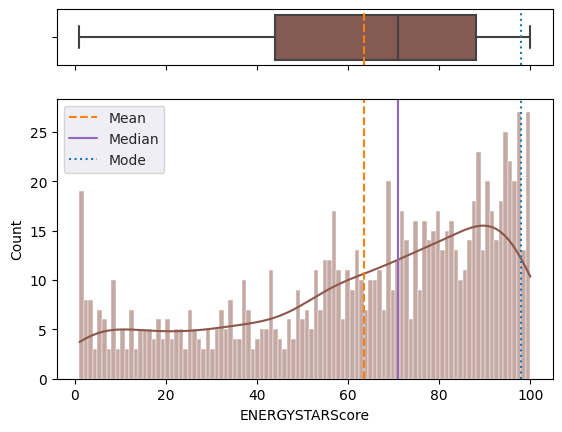

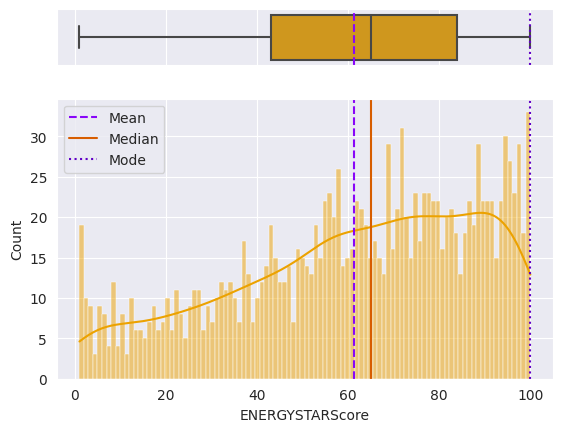

In [6]:
for df in [
    build_ener_df.loc[~build_ener_df["ENERGYSTARScore"].isna()].astype(
        {"ENERGYSTARScore": "int"}
    ),
    build_ener_df_enstr_intrp,
]:
    f, (ax_box, ax_hist) = plt.subplots(
        2, sharex=True, gridspec_kw={"height_ratios": (0.2, 1)}
    )
    mean = df["ENERGYSTARScore"].mean()
    median = df["ENERGYSTARScore"].median()
    mode = df["ENERGYSTARScore"].mode().values[0]
    theme_clrs = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    sns.set_palette("gnuplot")
    sns.set_style("darkgrid")
    sns.boxplot(data=df, x="ENERGYSTARScore", ax=ax_box, color=theme_clrs[5])
    ax_box.axvline(mean, color=theme_clrs[1], linestyle="--")
    ax_box.axvline(mode, color=theme_clrs[0], linestyle=":")
    sns.histplot(
        data=df,
        x="ENERGYSTARScore",
        ax=ax_hist,
        bins=100,
        kde=True,
        color=theme_clrs[5],
    )
    ax_hist.axvline(mean, color=theme_clrs[1], linestyle="--", label="Mean")
    ax_hist.axvline(median, color=theme_clrs[4], linestyle="-", label="Median")
    ax_hist.axvline(mode, color=theme_clrs[0], linestyle=":", label="Mode")
    ax_hist.legend()
    ax_box.set(xlabel="")
    plt.show()


In [7]:
contin_feats = [
    "Latitude",
    "Longitude",
    "YearBuilt",
    "NumberofBuildings",
    "NumberofFloors",
    "PropertyGFATotal",
    "PropertyGFAParking",
    "PropertyGFABuilding(s)",
    "LargestPropertyUseTypeGFA",
    "SecondLargestPropertyUseTypeGFA",
    "ThirdLargestPropertyUseTypeGFA",
    "ENERGYSTARScore",
]
categ_feats = [
    "BuildingType",
    "PrimaryPropertyType",
    "ZipCode",
    "CouncilDistrictCode",
    "Neighborhood",
    "LargestPropertyUseType",
    "SecondLargestPropertyUseType",
    "ThirdLargestPropertyUseType",
]
mm_scaler = MinMaxScaler(feature_range=(0, 1))


def remove_unusable(df):
    for col_name in [
        x for x in df.columns.to_list() if x not in contin_feats + categ_feats
    ]:
        df = df.drop(col_name, axis=1)

    return df


def normalize_contin(df):
    cf_lst = [x for x in df.columns.to_list() if x in contin_feats]

    with pd.option_context("mode.chained_assignment", None):
        df[cf_lst] = mm_scaler.fit_transform(df[cf_lst].to_numpy())

    return df


def one_hot_categs(df):
    for col_name in [x for x in df.columns.to_list() if x in categ_feats]:
        df = pd.concat(
            [df, pd.get_dummies(df[col_name], prefix=col_name)], axis=1
        ).drop(col_name, axis=1)

    return df


def preproc_pipe(df):
    return df.copy().pipe(remove_unusable).pipe(normalize_contin).pipe(one_hot_categs)


In [8]:
def get_metrics(model, X, y):
    n = len(X)
    p = len(X.columns)
    r2 = cross_val_score(model, X=X, y=y, scoring="r2").mean()
    r2_adj = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    rmse = abs(
        cross_val_score(model, X=X, y=y, scoring="neg_root_mean_squared_error").mean()
    )
    mae = abs(
        cross_val_score(model, X=X, y=y, scoring="neg_mean_absolute_error").mean()
    )

    return {
        "R^2": r2,
        "Adjusted R^2": r2_adj,
        "RMSE": rmse,
        "MAE": mae,
    }


target = build_ener_df["TotalGHGEmissions"]
dummy_metrics = {}

for build_ener_df_str in build_ener_dfs.keys():
    dummy_metrics[build_ener_df_str] = get_metrics(
        DummyRegressor(), preproc_pipe(build_ener_dfs[build_ener_df_str]), target
    )

display(dummy_metrics)


{'ENERGYSTARScore NaNs replaced by median': {'R^2': -0.12758463438777187,
  'Adjusted R^2': -0.35816529338446923,
  'RMSE': 698.8087138011664,
  'MAE': 243.21632791380662},
 'ENERGYSTARScore NaNs replaced by negative scores': {'R^2': -0.12758463438777187,
  'Adjusted R^2': -0.35816529338446923,
  'RMSE': 698.8087138011664,
  'MAE': 243.21632791380662},
 'ENERGYSTARScore NaNs imputed': {'R^2': -0.12758463438777187,
  'Adjusted R^2': -0.35816529338446923,
  'RMSE': 698.8087138011664,
  'MAE': 243.21632791380662},
 'ENERGYSTARScore with one-hot encoding': {'R^2': -0.12758463438777187,
  'Adjusted R^2': -0.3570770199122062,
  'RMSE': 698.8087138011664,
  'MAE': 243.21632791380662},
 'No ENERGYSTARScore used': {'R^2': -0.12758463438777187,
  'Adjusted R^2': -0.3570770199122062,
  'RMSE': 698.8087138011664,
  'MAE': 243.21632791380662}}

In [9]:
def get_contin_support_feats(estimator, X, y):
    rfe = RFE(estimator)
    grd_srch = GridSearchCV(
        estimator=rfe,
        param_grid={"n_features_to_select": list(range(1, len(contin_feats) + 1))},
        scoring="r2",
        cv=5,
    )
    X = preproc_pipe(X)[[x for x in X.columns if x in contin_feats]]

    grd_srch.fit(X, y)

    n_feats = grd_srch.best_params_["n_features_to_select"]
    adj_r2 = float("-inf")
    support_feats = []

    while n_feats <= len(contin_feats):
        rfe = RFE(estimator, n_features_to_select=n_feats)

        rfe.fit(X, y)

        new_support_feats = list(X.columns[rfe.support_])
        new_adj_r2 = get_metrics(estimator, X[new_support_feats], y)["Adjusted R^2"]

        if new_adj_r2 <= adj_r2:
            break
        else:
            n_feats += 1
            adj_r2 = new_adj_r2
            support_feats = new_support_feats

    return support_feats


def get_categ_support_feats(estimator, X, y):
    rfecv = RFECV(estimator=estimator, scoring="r2")
    X = preproc_pipe(X)
    X = X[[x for x in X.columns if x not in contin_feats]]

    rfecv.fit(X, y)

    return list(X.columns[rfecv.support_])


def get_support_feats(estimator, X, y):
    return get_contin_support_feats(estimator, X, y) + get_categ_support_feats(
        estimator, X, y
    )


In [10]:
def get_preproc_train_test_w_support_feats(model, X, y, **tts_kwargs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, **tts_kwargs)
    support_feats = get_support_feats(model, X_train, y_train)
    X_train, X_test = [preproc_pipe(X_train), preproc_pipe(X_test)]

    for feat in [x for x in support_feats if x not in X_train.columns.to_list()]:
        X_train[feat] = 0

    for feat in [x for x in support_feats if x not in X_test.columns.to_list()]:
        X_test[feat] = 0

    X_train, X_test = [X_train[support_feats], X_test[support_feats]]

    return [X_train, X_test, y_train, y_test]


for random_seed in [random.randint(0, 100) for i in range(0, 3)]:
    print(f"Train test split random seed: {random_seed}")

    for build_ener_df_str in build_ener_dfs.keys():
        lr_model = LinearRegression()
        X_train, X_test, y_train, y_test = get_preproc_train_test_w_support_feats(
            lr_model, build_ener_dfs[build_ener_df_str], target, random_state=random_seed,
        )
        lr_model.fit(X_train, y_train)
        metrics = get_metrics(lr_model, X_test, y_test)

        print(f"\t{build_ener_df_str}\n\tFeatures used: {X_train.columns.to_list()}")

        for metric in metrics.keys():
            print(
                f"\t\tDummy {metric}: {dummy_metrics[build_ener_df_str][metric]}\n\t\t{metric}: {metrics[metric]}"
            )

        print("")


Train test split random seed: 39
	ENERGYSTARScore NaNs replaced by median
	Features used: ['LargestPropertyUseTypeGFA', 'PrimaryPropertyType_Senior Care Community', 'PrimaryPropertyType_Worship Facility', 'ZipCode_98101.0', 'ZipCode_98112.0', 'ZipCode_98122.0', 'ZipCode_98145.0', 'ZipCode_98154.0', 'ZipCode_98164.0', 'LargestPropertyUseType_Senior Care Community', 'LargestPropertyUseType_Worship Facility']
		Dummy R^2: -0.12758463438777187
		R^2: 0.2954216735714705
		Dummy Adjusted R^2: -0.35816529338446923
		Adjusted R^2: 0.27412947139917976
		Dummy RMSE: 698.8087138011664
		RMSE: 295.51045561534204
		Dummy MAE: 243.21632791380662
		MAE: 136.45218218710846

	ENERGYSTARScore NaNs replaced by negative scores
	Features used: ['LargestPropertyUseTypeGFA', 'PrimaryPropertyType_Senior Care Community', 'PrimaryPropertyType_Worship Facility', 'ZipCode_98101.0', 'ZipCode_98112.0', 'ZipCode_98122.0', 'ZipCode_98145.0', 'ZipCode_98154.0', 'ZipCode_98164.0', 'LargestPropertyUseType_Senior Care Co

In [11]:
for random_seed in [random.randint(0, 100) for i in range(0, 3)]:
    print(f"Train test split random seed: {random_seed}")

    for build_ener_df_str in build_ener_dfs.keys():
        dtr_model = DecisionTreeRegressor()
        X_train, X_test, y_train, y_test = get_preproc_train_test_w_support_feats(
            dtr_model, build_ener_dfs[build_ener_df_str], target, random_state=random_seed,
        )
        dtr_model.fit(X_train, y_train)
        metrics = get_metrics(dtr_model, X_test, y_test)

        print(f"\t{build_ener_df_str}\n\tFeatures used: {X_train.columns.to_list()}")

        for metric in metrics.keys():
            print(
                f"\t\tDummy {metric}: {dummy_metrics[build_ener_df_str][metric]}\n\t\t{metric}: {metrics[metric]}"
            )

        print("")

Train test split random seed: 49
	ENERGYSTARScore NaNs replaced by median
	Features used: ['NumberofBuildings', 'PropertyGFATotal', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'BuildingType_Campus', 'PrimaryPropertyType_Hospital', 'ZipCode_98104.0', 'ZipCode_98105.0']
		Dummy R^2: -0.12758463438777187
		R^2: 0.05114984744773519
		Dummy Adjusted R^2: -0.35816529338446923
		Adjusted R^2: 0.027817466647269806
		Dummy RMSE: 698.8087138011664
		RMSE: 990.95560928295
		Dummy MAE: 243.21632791380662
		MAE: 240.49452807017548

	ENERGYSTARScore NaNs replaced by negative scores
	Features used: ['Longitude', 'NumberofBuildings', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'BuildingType_Campus', 'PrimaryPropertyType_Hospital', 'ZipCode_98104.0', 'ZipCode_98105.0']
		Dummy R^2: -0.12758463438777187
		R^2: -0.7364605561711187
		Dummy Adjusted R^2: -0.35816529338446923
		Adjusted R^2: -0.7743125573955572
		Dummy RMSE: 698.8087138011664
		RMSE: 1197.60454446802

In [16]:
def get_freq_support_feats(model, rand_range=100, n_runs=3, perc_thresh=50):
    if 0 >= perc_thresh or perc_thresh > 100:
        raise Exception(
            "'perc_thresh' parameter must be greater than 0 and less than or equal to 100."
        )

    feat_lists = []
    feat_counts = {}
    freq_feats = []

    for random_seed in [random.randint(0, rand_range) for i in range(0, n_runs)]:
        for build_ener_df_str in build_ener_dfs.keys():
            X_train, X_test, y_train, y_test = get_preproc_train_test_w_support_feats(
                model,
                build_ener_dfs[build_ener_df_str],
                target,
                random_state=random_seed,
            )

            feat_lists += [X_train.columns.to_list()]

    for feat_list in feat_lists:
        for feat in feat_list:
            if feat in feat_counts:
                feat_counts[feat] += 1
            else:
                feat_counts[feat] = 1

    for feat in feat_counts.keys():
        if feat_counts[feat] / len(feat_lists) >= perc_thresh / 100:
            freq_feats += [feat]

    return freq_feats


lr_support_feats = get_freq_support_feats(LinearRegression(), n_runs=6, perc_thresh=30)

print(lr_support_feats)


['LargestPropertyUseTypeGFA', 'Neighborhood_BALLARD', 'Neighborhood_DELRIDGE', 'Neighborhood_GREATER DUWAMISH', 'Neighborhood_NORTH', 'Neighborhood_SOUTHEAST']


In [17]:
for build_ener_df_str in build_ener_dfs.keys():
    lr_model = LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(
        preproc_pipe(build_ener_dfs[build_ener_df_str])[lr_support_feats],
        target,
        random_state=0,
    )
    lr_model.fit(X_train, y_train)
    metrics = get_metrics(lr_model, X_test, y_test)

    print(f"{build_ener_df_str}")

    for metric in metrics.keys():
        print(
            f"\tDummy {metric}: {dummy_metrics[build_ener_df_str][metric]}\n\t{metric}: {metrics[metric]}"
        )


ENERGYSTARScore NaNs replaced by median
	Dummy R^2: -0.12758463438777187
	R^2: -0.5161954708339431
	Dummy Adjusted R^2: -0.35816529338446923
	Adjusted R^2: -0.5408490557255521
	Dummy RMSE: 698.8087138011664
	RMSE: 509.38371442999903
	Dummy MAE: 243.21632791380662
	MAE: 200.33598861226298
ENERGYSTARScore NaNs replaced by negative scores
	Dummy R^2: -0.12758463438777187
	R^2: -0.5161954708339431
	Dummy Adjusted R^2: -0.35816529338446923
	Adjusted R^2: -0.5408490557255521
	Dummy RMSE: 698.8087138011664
	RMSE: 509.38371442999903
	Dummy MAE: 243.21632791380662
	MAE: 200.33598861226298
ENERGYSTARScore NaNs imputed
	Dummy R^2: -0.12758463438777187
	R^2: -0.5161954708339431
	Dummy Adjusted R^2: -0.35816529338446923
	Adjusted R^2: -0.5408490557255521
	Dummy RMSE: 698.8087138011664
	RMSE: 509.38371442999903
	Dummy MAE: 243.21632791380662
	MAE: 200.33598861226298
ENERGYSTARScore with one-hot encoding
	Dummy R^2: -0.12758463438777187
	R^2: -0.5161954708339431
	Dummy Adjusted R^2: -0.35707701991220

In [18]:
dt_support_feats = get_freq_support_feats(DecisionTreeRegressor(), n_runs=6, perc_thresh=30)

print(dt_support_feats)

['Latitude', 'Longitude', 'YearBuilt', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'BuildingType_Campus', 'BuildingType_NonResidential', 'BuildingType_Nonresidential COS', 'BuildingType_SPS-District K-12', 'PrimaryPropertyType_Hospital', 'PrimaryPropertyType_K-12 School', 'PrimaryPropertyType_Large Office', 'PrimaryPropertyType_Medical Office', 'PrimaryPropertyType_Mixed Use Property', 'PrimaryPropertyType_Other', 'PrimaryPropertyType_Restaurant', 'PrimaryPropertyType_Small- and Mid-Sized Office', 'PrimaryPropertyType_Supermarket / Grocery Store', 'ZipCode_98101.0', 'ZipCode_98102.0', 'ZipCode_98103.0', 'ZipCode_98104.0', 'ZipCode_98105.0', 'ZipCode_98106.0', 'ZipCode_98107.0', 'ZipCode_98108.0', 'ZipCode_98109.0', 'ZipCode_98112.0', 'ZipCode_98115.0', 'ZipCode_98117.0', 'ZipCode_98119.0', 'ZipCode_98122.0', 'ZipCode_98125.0', 'Z

In [34]:
if not os.path.isfile("grd_srch_cv_dtr.pkl"):
    dt_hyperparams = {
        "criterion": ["squared_error", "absolute_error"],
        "splitter": ["best", "random"],
        "max_depth": [2, 4, 8, 16, None],
        "min_samples_split": [2, 4, 8, 16],
        "min_samples_leaf": [1, 2, 4, 8],
        "min_weight_fraction_leaf": [0, 0.2, 0.4],
        "max_features": ["log2", "sqrt", None],
        "max_leaf_nodes": [20, 40, 60, 80, 100, None],
    }

    grd_srch_cv_dtr = GridSearchCV(DecisionTreeRegressor(), dt_hyperparams, cv=5)

    grd_srch_cv_dtr.fit(
        preproc_pipe(build_ener_dfs["ENERGYSTARScore NaNs imputed"])[dt_support_feats],
        target,
    )

    with open("grd_srch_cv_dtr.pkl", "wb") as f:
        pickle.dump(grd_srch_cv_dtr, f)
else:
    with open("grd_srch_cv_dtr.pkl", "rb") as f:
        grd_srch_cv_dtr = pickle.load(f)


In [35]:
display(grd_srch_cv_dtr.best_params_)


{'criterion': 'absolute_error',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0,
 'splitter': 'random'}

In [36]:
dtr_model = DecisionTreeRegressor(**grd_srch_cv_dtr.best_params_)

print(dummy_metrics["ENERGYSTARScore NaNs imputed"])
print(
    get_metrics(
        dtr_model,
        preproc_pipe(build_ener_dfs["ENERGYSTARScore NaNs imputed"])[dt_support_feats],
        target,
    )
)


{'R^2': -0.12758463438777187, 'Adjusted R^2': -0.35816529338446923, 'RMSE': 698.8087138011664, 'MAE': 243.21632791380662}
{'R^2': 0.30414074555818205, 'Adjusted R^2': 0.2303530190194325, 'RMSE': 562.1090353516408, 'MAE': 148.28478021040976}


In [38]:
def get_validation_metrics(X_test, y_test, y_pred):
    n = len(X_test)
    p = len(X_test.columns)
    r2 = r2_score(y_test, y_pred=y_pred)
    r2_adj = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    rmse = mean_squared_error(y_test, y_pred=y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred=y_pred)

    return {
        "R^2": r2,
        "Adjusted R^2": r2_adj,
        "RMSE": rmse,
        "MAE": mae,
    }

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    preproc_pipe(build_ener_dfs["ENERGYSTARScore NaNs imputed"])[dt_support_feats],
    target,
)

dtr_model.fit(X_train, y_train)

y_pred = dtr_model.predict(X_test)

print(dummy_metrics["ENERGYSTARScore NaNs imputed"])
print(get_validation_metrics(X_test, y_test, y_pred))

{'R^2': -0.12758463438777187, 'Adjusted R^2': -0.35816529338446923, 'RMSE': 698.8087138011664, 'MAE': 243.21632791380662}
{'R^2': 0.2376089160548004, 'Adjusted R^2': -0.23764786354740197, 'RMSE': 455.41712661072853, 'MAE': 143.51162234042553}


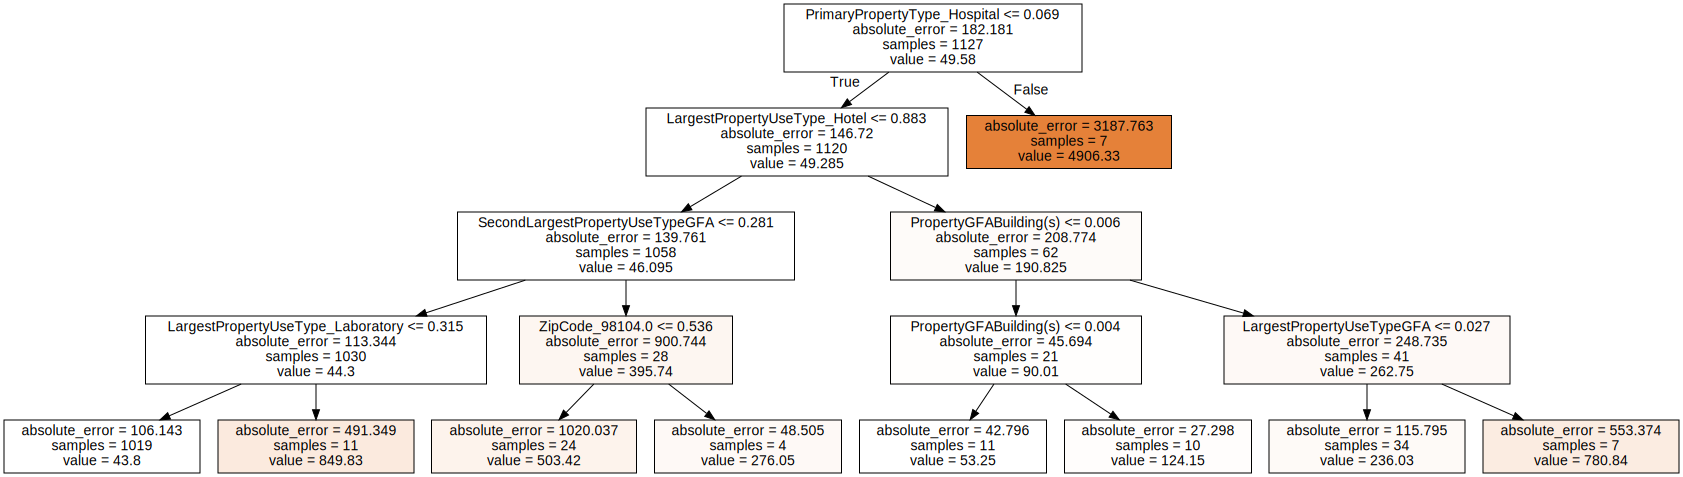

In [46]:
dot_data = export_graphviz(
    dtr_model, out_file=None, feature_names=X_train.columns, filled=True
)

graphviz.Source(dot_data, format="png")


In [53]:
if not os.path.isfile("grd_srch_cv_rfr.pkl"):
    rfr_model = RandomForestRegressor(
        **{
            key: value
            for key, value in grd_srch_cv_dtr.best_params_.items()
            if key != "splitter"
        }
    )
    rfr_hyperparams = {"n_estimators": [50, 100, 200, 300, 400, 500]}
    grd_srch_cv_rfr = GridSearchCV(rfr_model, rfr_hyperparams, cv=5)

    grd_srch_cv_rfr.fit(
        preproc_pipe(build_ener_dfs["ENERGYSTARScore NaNs imputed"])[dt_support_feats],
        target,
    )

    with open("grd_srch_cv_rfr.pkl", "wb") as f:
        pickle.dump(grd_srch_cv_rfr, f)
else:
    with open("grd_srch_cv_rfr.pkl", "rb") as f:
        grd_srch_cv_rfr = pickle.load(f)

display(grd_srch_cv_rfr.best_params_)


{'n_estimators': 100}

In [79]:
if not os.path.isfile("rfr_metrics.pkl"):
    n_runs = 50
    rfr_model = RandomForestRegressor(
        **{
            key: value
            for key, value in grd_srch_cv_dtr.best_params_.items()
            if key != "splitter"
        },
        **grd_srch_cv_rfr.best_params_
    )
    rfr_metrics = {
        "With ENERGYSTARScore": {"RMSE": [], "MAE": []},
        "Without ENERGYSTARScore": {"RMSE": [], "MAE": []},
    }

    for i in range(n_runs):
        X_train, X_test, y_train, y_test = train_test_split(
            preproc_pipe(build_ener_dfs["ENERGYSTARScore NaNs imputed"])[
                dt_support_feats
            ],
            target,
        )

        rfr_model.fit(X_train, y_train)

        y_pred = rfr_model.predict(X_test)
        val_metrics = get_validation_metrics(X_test, y_test, y_pred)
        rfr_metrics["With ENERGYSTARScore"]["RMSE"] += [val_metrics["RMSE"]]
        rfr_metrics["With ENERGYSTARScore"]["MAE"] += [val_metrics["MAE"]]

        X_train, X_test = [
            X_train.drop(["ENERGYSTARScore"], axis=1),
            X_test.drop(["ENERGYSTARScore"], axis=1),
        ]

        rfr_model.fit(X_train, y_train)

        y_pred = rfr_model.predict(X_test)
        val_metrics = get_validation_metrics(X_test, y_test, y_pred)
        rfr_metrics["Without ENERGYSTARScore"]["RMSE"] += [val_metrics["RMSE"]]
        rfr_metrics["Without ENERGYSTARScore"]["MAE"] += [val_metrics["MAE"]]

    with open("rfr_metrics.pkl", "wb") as f:
        pickle.dump(rfr_metrics, f)
else:
    with open("rfr_metrics.pkl", "rb") as f:
        rfr_metrics = pickle.load(f)


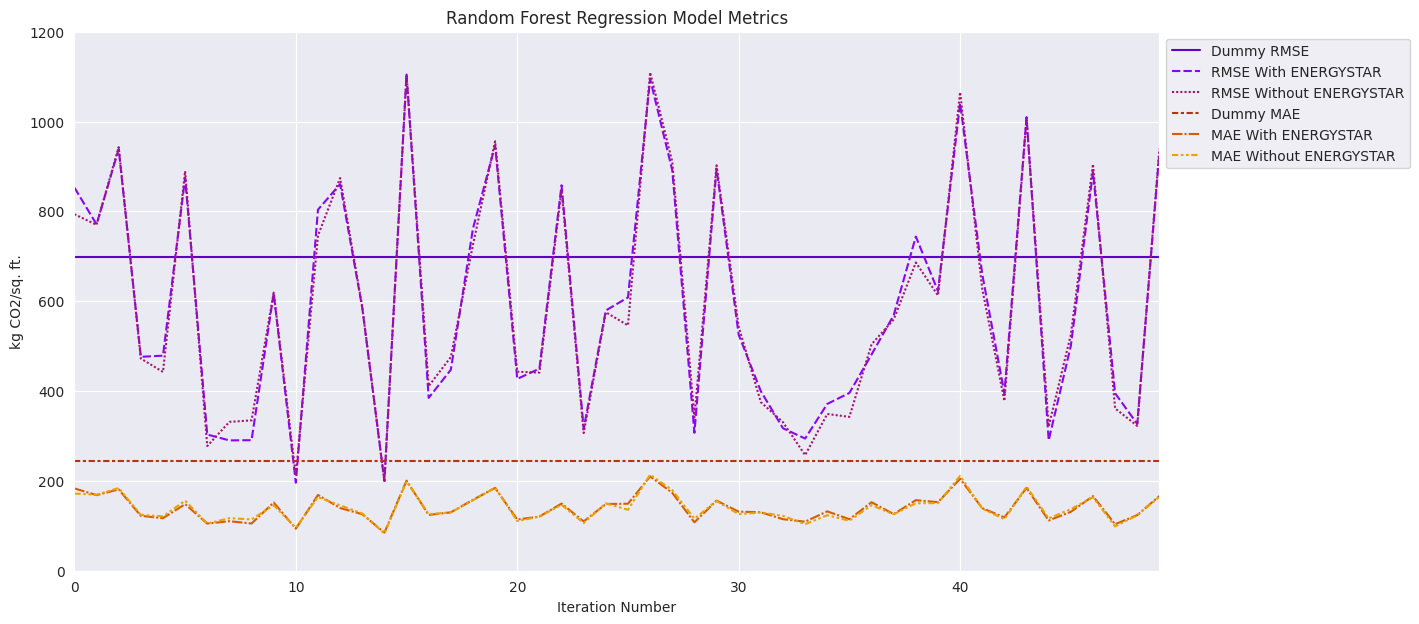

In [90]:
n_runs = len(rfr_metrics["With ENERGYSTARScore"]["RMSE"])
rfr_metrics_df = pd.DataFrame(
    {
        "Dummy RMSE": [dummy_metrics["ENERGYSTARScore NaNs imputed"]["RMSE"]] * n_runs,
        "RMSE With ENERGYSTAR": rfr_metrics["With ENERGYSTARScore"]["RMSE"],
        "RMSE Without ENERGYSTAR": rfr_metrics["Without ENERGYSTARScore"]["RMSE"],
        "Dummy MAE": [dummy_metrics["ENERGYSTARScore NaNs imputed"]["MAE"]] * n_runs,
        "MAE With ENERGYSTAR": rfr_metrics["With ENERGYSTARScore"]["MAE"],
        "MAE Without ENERGYSTAR": rfr_metrics["Without ENERGYSTARScore"]["MAE"],
    }
)

f, ax = plt.subplots(figsize=(14, 7))
rfr_lp = sns.lineplot(rfr_metrics_df, ax=ax)

rfr_lp.set_title("Random Forest Regression Model Metrics")
rfr_lp.set_xlabel("Iteration Number")
rfr_lp.set_ylabel("kg CO2/sq. ft.")
rfr_lp.set(xlim=(0, 49))
rfr_lp.set(ylim=(0, 1200))
rfr_lp.legend(bbox_to_anchor=(1, 1))
plt.show()
